# Bandit算法学习[网站优化]04——UCB(Upper Confidence Bound) 算法

## 参考资料

1. White J. Bandit algorithms for website optimization[M]. " O'Reilly Media, Inc.", 2013.
2. [https://github.com/johnmyleswhite/BanditsBook](https://github.com/johnmyleswhite/BanditsBook)
3. [UCB算法原理及其在星际争霸比赛中的应用](https://zhuanlan.zhihu.com/p/37530615)
4. [Auer P, Cesa-Bianchi N, Fischer P. Finite-time analysis of the multiarmed bandit problem[J]. Machine learning, 2002, 47(2): 235-256.](https://link.springer.com/article/10.1023/A:1013689704352)

实验环境：jupyter python 3.7

UCB（Upper Confidence Bound - 置信上限）就是以均值的置信上限为来代表它的预估值。

## 一、UCB算法介绍

到目前为止，我们所介绍的算法有一个系统性的弱点：它们没有跟踪对任何可用臂的了解程度。这些算法只注意从臂中获得了多少奖励。我们可以通过使用一个不仅关注`what it knows`，而且关注`how much it knows`的算法来做得更好。而本文中介绍的算法UCB就是这样做的。

让我们回顾一下epsilon-Greedy和Softmax算法，并从更抽象的角度来看待它们。epsilon-Greedy算法和Softmax算法都具有以下属性:

+ 算法默认选择当前具有最高估计值的臂。

+ 算法有时会决定探索并选择一个当前看起来不是最好的选项

    + epsilon-Greedy算法通过完全随机地从所有臂中选择来进行探索。用概率ε作为这些随机的探索性决策之一。
    
    + Softmax算法通过从所有可用的臂中随机选择，其概率与每个臂的估计值成正比。**如果其他臂明显比最好的武器差，就会以很低的概率选择它们。如果这些臂都有类似的价值，它们被选择的概率几乎相同**。

+ 可以使用退火法将这两种算法设置为随时间动态地修改它们的基本参数。

UCB算法对上述属性做出的改进为：它可以由我们选择的臂的估计值的置信度（confidence）来驱动探索。

> 置信区间是指由样本统计量所构造的总体参数的估计区间。
>
> 置信区间的解释: [机器学习笔记 - 什么是置信区间？](https://blog.csdn.net/bashendixie5/article/details/124120896)

那为什么跟踪臂估计值的置信度十分重要?因为从臂收获到的奖励是有噪声的（noisy）。如果我们使用过去对一个臂的经验，那么任何臂的估计值总是真实值的一个有噪声的估计。epsilon-Greedy算法和Softmax算法对这种噪声不具有鲁棒性。简而言之，epsilon-Greedy和Softmax算法**很容易被一些负面的经验所误导**。这是由于它们使用了随机化，不过可以在以后弥补这一缺陷。而UCB采取的是一种非常不同的方法。

UCB要求我们在评估所有武器的估计价值时跟踪置信度，以避免‘被欺骗’。要做到这一点，需要有衡量我们对每只臂了解多少的指标：可以利用算法中的`counts`字段。


在本书中，我们将只关注UCB系列中的一种算法——UCB1算法。

除了追踪置信度，UCB还有其他特点：

- 不使用随机性。

- 不需要设置相关参数，如前面两种算法的`epsilon`和`temperature`。

## 二、UCB算法的原理

UCB1的算法伪代码如下：

Repeat:

+ ​	if $n_i = 0$ for some $i\in 1...K$ play $i$

+ ​	else play $i = \text{argmax}\{\hat\mu_j + \sqrt{\frac{2\log N}{n_j}}\ ,\ \ j=1...K\}$

+ ​	let $r$ be the associated reward

+ ​	Update $n_i$ and $\hat\mu_i$

    + ​	$\hat\mu_i :=\frac{1}{n_i+1}\times (n_i\mu_i+r)$

    +  $n_i:=n_i +1$

+ ​	$N:=N+1$

各个参数的意义如下：

+ $n_i$：第$i$个臂被拉的次数。

+ $K$：臂的数量

+ $\hat\mu_i$：第$i$个臂的平均奖励

+ $N$：所有臂拉的次数之和

+ $r$：拉第$i$个臂获得的奖励

其中置信度为$1-\frac{2}{N}$，置信区间上限为$\hat\mu_j + \sqrt{\frac{2\log N}{n_j}}$。

对于多个赌博机而言，给定置信度比如0.95，在同一个置信度的水平，选择最大的上置信界最大的作为选择策略。

在相同的置信度下，策略的选择由两部分组成，一部分为每个赌博机目前位置的平均收益，另外一部分为赌博机尝试次数反比例函数，因此UCB算法不仅考虑平均收益而且考虑尝试次数，相同平均收益的情况下，尝试次数少的赌博机更受到青睐，即UCB算法取上置信界，即**乐观主义者(用较少的探索次数得到相同的收益，自信该赌博机在后面的探索中会得到更高的收益)**。

## 三、UCB算法的实现

使用python编写，实现如下：

In [1]:
import math


def index_max(x):
    """  
    获取向量x的最大值的索引
    """
    m = max(x)
    return x.index(m)


class UCB1():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        n_arms = len(self.counts)
        # 确保所有的臂都至少玩了一次
        # 从而可以对所有可用的臂有一个初始化的了解
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        for arm in range(n_arms):
            # 使用置信区间上界
            # 置信度为1-2/total_counts
            bonus = math.sqrt((2 * math.log(total_counts)) /
                              float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + bonus

        return index_max(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return


对该算法进行评估，跟踪每个时间点的平均奖励：

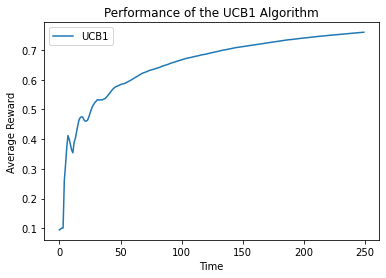

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt


class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0


def get_cumulative_reward(algo, arms, num_sims, horizon):

    result = []

    for sim in range(num_sims):
        cumulative_rewards = [0.0 for i in range(horizon)]
        algo.initialize(len(arms))
        for t in range(horizon):
            t = t + 1
            index = t - 1

            # 选择臂
            chosen_arm = algo.select_arm()

            # 模拟拉动臂的结果
            reward = arms[chosen_arm].draw()

            # 记录算法收到的奖励金，然后调用更新
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)
        result.append(cumulative_rewards)

    # 多次模拟求平均
    average = np.sum(np.array(result), axis=0) / num_sims

    return list(average)


def draw_average_reward(arms, num_sims=5000, times=250):

    algo = UCB1([], [])
    algo.initialize(len(arms))
    cumulative_rewards = get_cumulative_reward(algo, arms, num_sims, times)

    average = list(
        map(lambda x: x / (cumulative_rewards.index(x) + 1),
            cumulative_rewards))


    plt.plot(average, label='UCB1')


    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.title('Performance of the UCB1 Algorithm')
    plt.show()


def draw_cumulative_reward(arms, num_sims=5000, times=250):

    algo = UCB1([], [])
    algo.initialize(len(arms))
    cumulative_rewards = get_cumulative_reward(algo, arms, num_sims, times)
    plt.plot(cumulative_rewards, label='UCB1')


    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title('Performance of the UCB1 Algorithm')
    plt.show()

means = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

draw_average_reward(arms)


可以看到，一开始存在振荡，后来逐渐平稳。噪声的存在是因为UCB对于一些臂了解太少，从而产生倒退，随着实验的进行，这种倒退会越来越少。

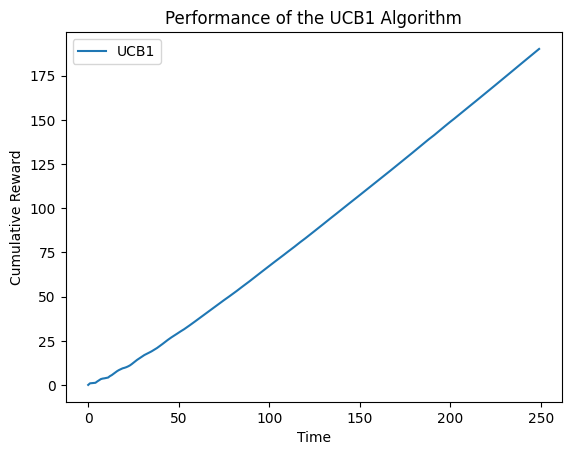

In [23]:
draw_cumulative_reward(arms)

## 四、不同bandit算法的比较

接下来让我们使用epsilon-Greedy算法和Softmax算法的退火版本与UCB1算法进行对比，这省去了对参数的调整。

由下面的对比图，我们可以发现：

+ UCB1的行为要更为的嘈杂

+ epsilon-Greedy算法的表现不如Softmax算法。

+ UCB1所做的后退导致它在大多数指标上的表现逊于Softmax算法，在其他环境下UCB1也许会表现得比Softmax好。

<img src="https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230106131837364.png" alt="image-20230106131837364" style="zoom: 35%;" />
<img src="https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230106132124989.png" alt="image-20230106132124989" style="zoom: 43%;" />

## 五、UCB算法的进一步探索

### 5.1 不同臂的奖励概率近似时

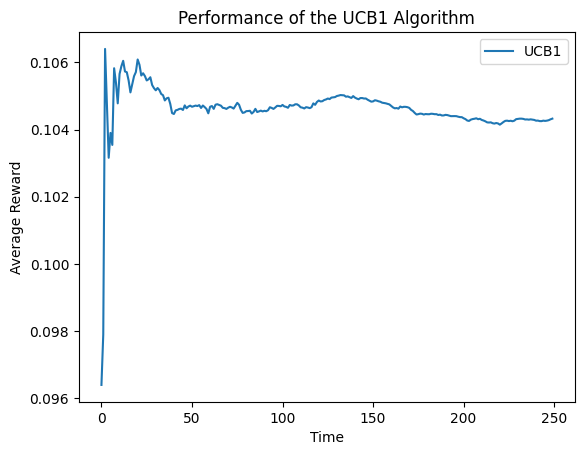

In [19]:
means2 = [0.1, 0.1, 0.1, 0.1, 0.12]
random.shuffle(means2)
arms2 = list(map(lambda mu:BernoulliArm(mu), means2))
draw_average_reward(arms2)

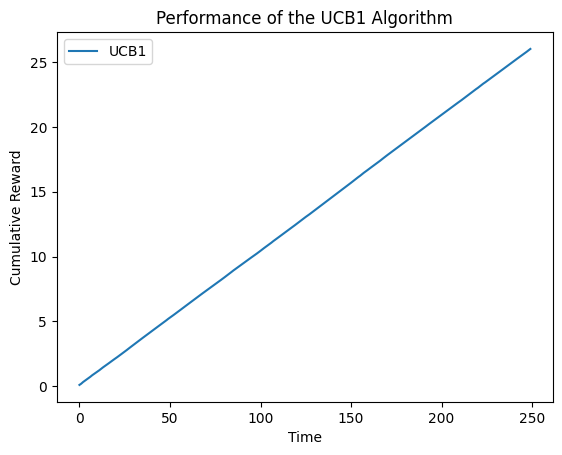

In [20]:
draw_cumulative_reward(arms2)

### 5.2 改变臂的数量

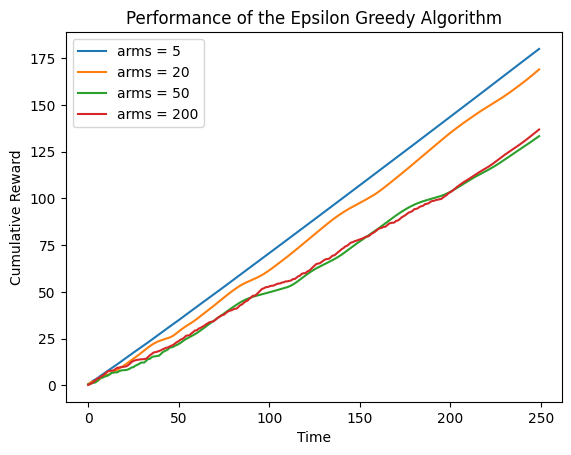

In [26]:
arms = []
nums = [5, 20, 50, 200]

# 随机生成数据
for num in nums:
    temp = [0.0 for col in range(num)]
    for i in range(num):
        temp[i] = random.random()
    means = list(map(lambda mu: BernoulliArm(mu), temp))
    arms.append(means)

result = []

for ar in arms:
    algo = UCB1( [], [])
    algo.initialize(len(ar))
    cumulative_rewards = get_cumulative_reward(algo, ar, 5000, 250)

    result.append(cumulative_rewards)

i = 0
for res in result:
    plt.plot(res, label='arms = {0}'.format(nums[i]))
    i += 1

plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.title('Performance of the Epsilon Greedy Algorithm')
plt.show()